In [1]:
import os
import sys

sys.path.append(os.pardir)
from src import registration
from src.datasets import CoronalScanPairsDataset
from train_contrastive_networks import load_model_and_optimisers

DS_ROOT = '/work/rhydian/UKBB_Downloads'
USE_CUDA= False
MODEL_PATH = '../model_weights/SSECEncoders/'
ENCODING_DIMENSION = 128

# load dataset and models
test_ds = CoronalScanPairsDataset(DS_ROOT,'test',augment=False,pad_scans=False)

dxa_model, mri_model, _,_,epochs = load_model_and_optimisers('VGGEncoder',ENCODING_DIMENSION,
                                                            MODEL_PATH,USE_CUDA,
                                                            ['fat_scan','water_scan'],
                                                            ['bone','tissue'],
                                                            0.1,(0.9,0.999))
dxa_model.eval(); mri_model.eval()
assert epochs>0, print('Model not trained!')

Trying to load model from ../model_weights/SSECEncoders/
==> Resuming model trained for 77 epochs...


/users/rhydian/anaconda3/envs/torch_env/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Encode & Visualize Scans

Encoding Scans...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


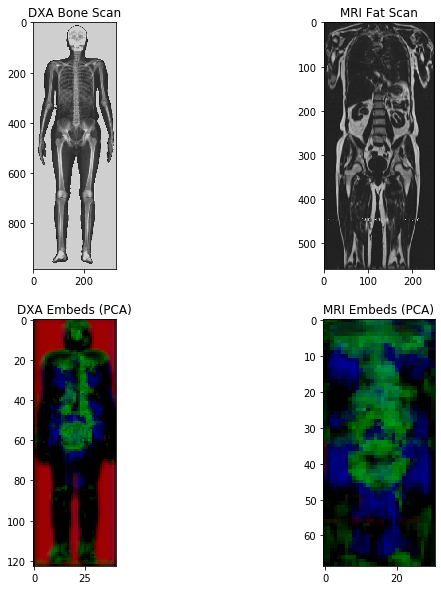

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch
from sklearn.manifold import TSNE
pca = PCA(n_components=3)


sample = test_ds[5]

print('Encoding Scans...')
with torch.no_grad():
    dxa_encoding = F.normalize(dxa_model(sample['dxa_img'][None]),dim=1)[0]
    mri_encoding = F.normalize(mri_model(sample['mri_img'][None]),dim=1)[0]

flat_dxa_encoding = dxa_encoding.flatten(start_dim=1)
flat_mri_encoding = mri_encoding.flatten(start_dim=1)
features = torch.cat([flat_dxa_encoding, flat_mri_encoding],dim=-1).T
tsne_encodings = pca.fit_transform(features)
dxa_tsne_encodings = tsne_encodings[:flat_dxa_encoding.shape[1]].reshape(dxa_encoding.shape[-2],dxa_encoding.shape[-1],3)
mri_tsne_encodings = tsne_encodings[flat_dxa_encoding.shape[1]:].reshape(mri_encoding.shape[-2],mri_encoding.shape[-1],3)


plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('DXA Bone Scan')
plt.imshow(sample['dxa_img'][0],cmap='gray')
plt.subplot(222)
plt.title('MRI Fat Scan')
plt.imshow(sample['mri_img'][0],cmap='gray')
plt.subplot(223)
plt.title('DXA Embeds (PCA)')
plt.imshow(dxa_tsne_encodings)
plt.subplot(224)
plt.title('MRI Embeds (PCA)')
plt.imshow(mri_tsne_encodings)
plt.show()



# Perform Registration using Dense Correspondance Matching

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


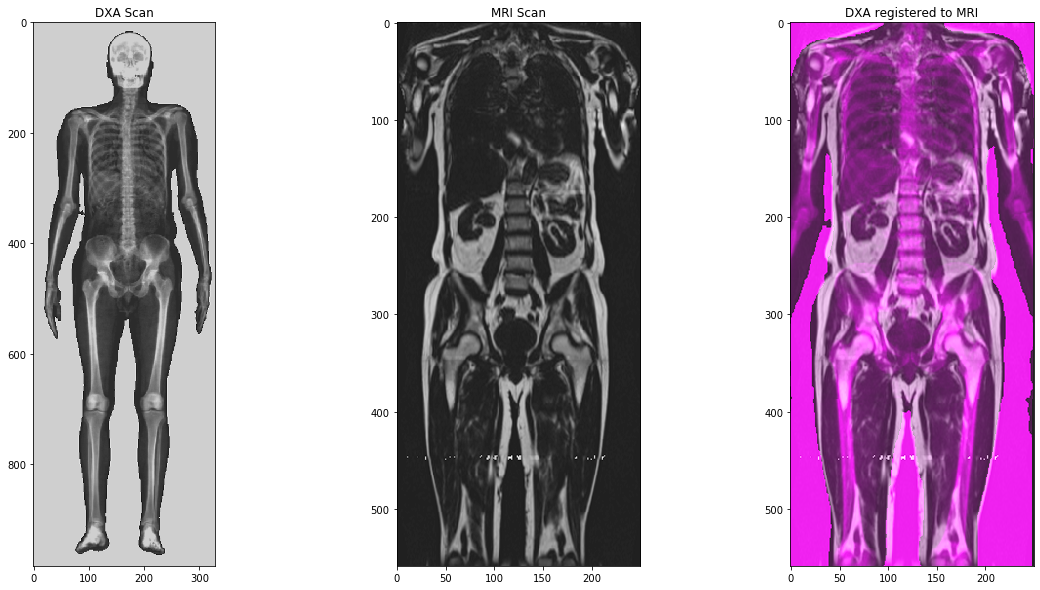

In [7]:
from src.registration import get_dense_correspondances, register_scans
import numpy as np

def purple(x):
    y = np.zeros_like(x)
    return np.stack([x,y,x],axis=-1)
def grayscale(x):
    y = np.zeros_like(x)
    return np.stack([x,x,x],axis=-1)
# Calculate registration transform by dense correspondance matching
TRY_ROTATION_RANGE=(-2,2)
ROTATION_POINTS_TO_TRY = 10
UPSAMPLE_FACTOR=2

M, t, angle = get_dense_correspondances(sample['dxa_img'],sample['mri_img'],dxa_model,mri_model, 
                                        USE_CUDA,UPSAMPLE_FACTOR,TRY_ROTATION_RANGE,ROTATION_POINTS_TO_TRY)
transformed_dxa = register_scans(sample['dxa_img'],sample['mri_img'], (-t[0], -t[1]),-angle)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('DXA Scan')
plt.imshow(sample['dxa_img'][0],cmap='gray')
plt.subplot(132)
plt.title('MRI Scan')
plt.imshow(sample['mri_img'][0],cmap='gray')
plt.subplot(133)
plt.title('DXA registered to MRI')
plt.imshow(purple(transformed_dxa[0])+grayscale(sample['mri_img'])[0])
plt.show()
plt.close('all')

# Perform Registration Using Lowes' Correspondance Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


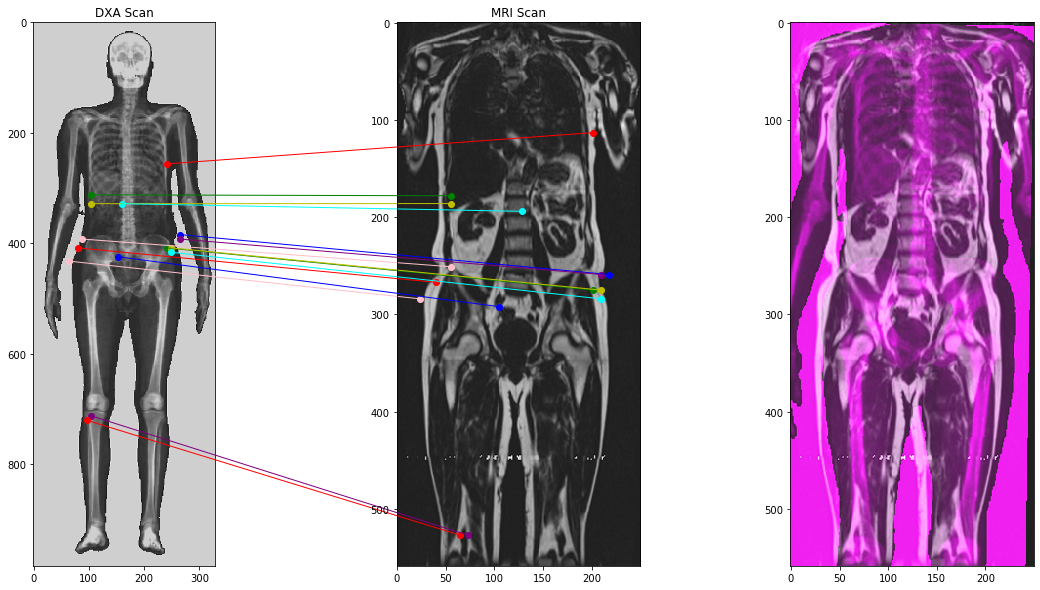

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


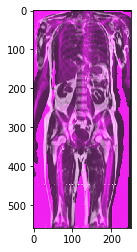

In [64]:
from src.registration import get_salient_point_correspondances
from matplotlib.patches import ConnectionPatch
matches, M, angle, t = get_salient_point_correspondances(sample['dxa_img'][None],sample['mri_img'][None],dxa_model, mri_model,0.93,True,15,False)

plt.figure(figsize=(20,10))
ax1=plt.subplot(131)
plt.title('DXA Scan')
plt.imshow(sample['dxa_img'][0],cmap='gray')
ax2=plt.subplot(132)
plt.title('MRI Scan')
plt.imshow(sample['mri_img'][0],cmap='gray')
plt.subplot(133)
plt.title('DXA registered to MRI')
transformed_dxa = register_scans(sample['dxa_img'],sample['mri_img'], (t[0], t[1]),angle)
plt.imshow(purple(transformed_dxa[0])+grayscale(sample['mri_img'])[0])

cycler = ['r','g','y','cyan','b','pink','purple']
for idx, match in enumerate(matches):
    c = cycler[idx%len(cycler)]
    ax1.scatter(match[0,1],match[0,0],c=c)
    ax2.scatter(match[1,1],match[1,0],c=c)
    con = ConnectionPatch(xyA=[match[0,1],match[0,0]], xyB=[match[1,1],match[1,0]], 
    coordsA="data", coordsB="data", axesA=ax1, axesB=ax2,color=c)
    ax2.add_artist(con)

plt.show()




In [10]:
matches.shape

(11, 2, 2)